## Model

#### Equations

\begin{equation}
\begin{split}
\dot{S} &= -\beta_1 I_1 S -\beta_2 I_2 S - \beta_3 I_3 S\\
\dot{E} &=\beta_1 I_1 S +\beta_2 I_2 S + \beta_3 I_3 S - a E \\
\dot{I_1} &= a E - \gamma_1 I_1 - p_1 I_1 \\
\dot{I_2} &= p_1 I_1 -\gamma_2 I_2 - p_2 I_2 \\
\dot{I_3} & = p_2 I_2 -\gamma_3 I_3 - \mu I_3 \\
\dot{R} & = \gamma_1 I_1 + \gamma_2 I_2 + \gamma_3 I_3 \\
\dot{D} & = \mu I_3
\end{split}
\end{equation}

####Variables
* $S$: Susceptible individuals
* $E$: Exposed individuals - infected but not yet infectious or symptomatic
* $I_i$: Infected individuals in severity class $i$. Severity increaes with $i$ and we assume individuals must pass through all previous classes
  * $I_1$: Mild infection (hospitalization not required)
  * $I_2$: Severe infection (hospitalization required)
  * $I_3$: Critical infection (ICU required)
* $R$: individuals who have recovered from disease and are now immune
* $D$: Dead individuals
* $N=S+E+I_1+I_2+I_3+R+D$ Total population size (constant)

#### Parameters
* $\beta_i$ rate at which infected individuals in class $I_i$ contact susceptibles and infect them
* $a$ rate of progression from the exposed to infected class
* $\gamma_i$ rate at which infected individuals in class $I_i$ recover from disease and become immune
* $p_i$ rate at which infected individuals in class $I_i$ progress to class $I_{I+1}$
* $\mu$ death rate for individuals in the most severe stage of disease

#### Basic reproductive ratio

Idea: $R_0$ is the sum of 
1. the average number of secondary infections generated from an individual in stage $I_1$
2. the probability that an infected individual progresses to $I_2$ multiplied by the average number of secondary infections generated from an individual in stage $I_2$
3.  the probability that an infected individual progresses to $I_3$ multiplied by the average number of secondary infections generated from an individual in stage $I_3$

\begin{equation}
\begin{split}
R_0 & = N\frac{\beta_1}{p_1+\gamma_1} + \frac{p_1}{p_1 + \gamma_1} \left( \frac{N \beta_2}{p_2+\gamma_2} + \frac{p_2}{p_2 + \gamma_2} \frac{N \beta_3}{\mu+\gamma_3}\right)\\
&= N\frac{\beta_1}{p_1+\gamma_1} \left(1 + \frac{p_1}{p_2 + \gamma_2}\frac{\beta_2}{\beta_1} \left( 1 + \frac{p_2}{\mu + \gamma_3} \frac{\beta_3}{\beta_2} \right) \right)
\end{split}
\end{equation}

In [0]:
import numpy as np, matplotlib.pyplot as plt
from scipy.integrate import odeint

In [0]:
#Defining the differential equations

#Don't track S because all variables must add up to 1 
#include blank first entry in vector for beta, gamma, p so that indices align in equations and code. 
#In the future could include recovery or infection from the exposed class (asymptomatics)

def seir(y,t,b,a,g,p,u,N): 
    dy=[0,0,0,0,0,0]
    S=N-sum(y);
    dy[0]=np.dot(b[1:3],y[1:3])*S-a*y[0] # E
    dy[1]= a*y[0]-(g[1]+p[1])*y[1] #I1
    dy[2]= p[1]*y[1] -(g[2]+p[2])*y[2] #I2
    dy[3]= p[2]*y[2] -(g[3]+u)*y[3] #I3
    dy[4]= np.dot(g[1:3],y[1:3]) #R
    dy[5]=u*y[3] #D

    return dy

In [0]:
# Define parameters based on clinical observations

#I will add sources soon
# https://github.com/midas-network/COVID-19/tree/master/parameter_estimates/2019_novel_coronavirus

IncubPeriod=5  #Incubation period, days
DurMildInf=10 #Duration of mild infections, days
FracMild=0.8  #Fraction of infections that are mild
FracSevere=0.15 #Fraction of infections that are severe
FracCritical=0.05 #Fraction of infections that are critical
CFR=0.02 #Case fatality rate (fraction of infections resulting in death)
TimeICUDeath=7 #Time from ICU admission to death, days
DurHosp=11 #Duration of hospitalization, days


In [75]:
# Define parameters and run ODE

N=1000
b=np.zeros(4) #beta
g=np.zeros(4) #gamma
p=np.zeros(3)

a=1/IncubPeriod

u=(1/TimeICUDeath)*(CFR/FracCritical)
g[3]=(1/TimeICUDeath)-u

p[2]=(1/DurHosp)*(FracCritical/FracSevere)
g[2]=(1/DurHosp)-p[2]

g[1]=(1/DurMildInf)*FracMild
p[1]=(1/DurMildInf)-g[1]

#b=2e-4*np.ones(4) # all stages transmit equally
b=2.5e-4*np.array([0,1,0,0]) # hospitalized cases don't transmit

#Calculate basic reproductive ratio
R0=N*((b[1]/(p[1]+g[1]))+(p[1]/(p[1]+g[1]))*(b[2]/(p[2]+g[2])+ (p[2]/(p[2]+g[2]))*(b[3]/(u+g[3]))))
print(R0)

2.5


(0, 1000)

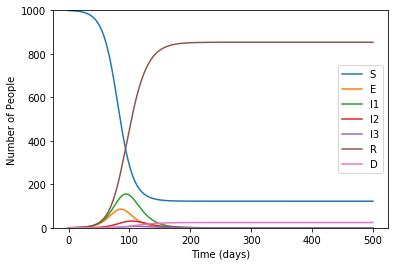

In [76]:
tmax=500
tvec=np.arange(0,tmax,0.1)
ic=np.zeros(6)
ic[0]=1

soln=odeint(seir,ic,tvec,args=(b,a,g,p,u,N))
soln=np.hstack((N-np.sum(soln,axis=1,keepdims=True),soln))

plt.plot(tvec,soln)
plt.xlabel("Time (days)")
plt.ylabel("Number of People")
plt.legend(("S","E","I1","I2","I3","R","D"))
plt.ylim([0,1000])

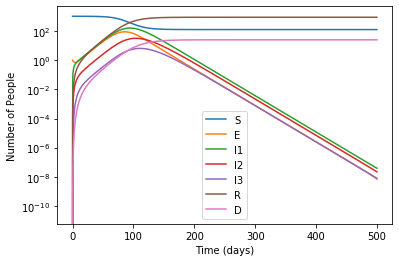

In [77]:
plt.plot(tvec,soln)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number of People")
plt.legend(("S","E","I1","I2","I3","R","D"))

In [78]:
# get observed growth rate r (and doubling time) of E
t1=10
t2=20
i1=np.where(tvec==t1)[0][0]
i2=np.where(tvec==t2)[0][0]
r=(np.log(soln[i2,1])-np.log(soln[i1,1]))/(t2-t1)
print(r)

DoublingTime=np.log(2)/r
print(DoublingTime)

0.0770121483522256
9.00049142103843
